In [1]:
# import the necessary packages
import os

from scipy.fft import fft2

import numpy as np
from PIL import Image
import cv2

import tqdm
import matplotlib.pyplot as plt
plt.rcParams["figure.dpi"] = 150

import stitching as st

from IPython.display import clear_output

In [6]:
imagePath = '/home/jack/Videos/map_2_images/'
imageExtension = 'png'
fileTemplateName = 'image'

stitcherSettings = {'detector': 'sift',
                    'matcher_type': 'affine',
                    'confidence_threshold': 1.,
                    'crop': False}

stitchKernel = 1
stitchImageSkip = 2
approxColumnSize = 1000
columnOverlap = 20

images = [imagePath + i for i in os.listdir(imagePath) if imageExtension in i]
imageIndexing = [int(img.split(fileTemplateName)[-1].split('.')[0]) for img in images]

images = np.array(images)[np.argsort(imageIndexing)]

def filter(img):
    return st.filterBackground(st.equalizeSpatialGradients(img), tolerance=.005)

100%|█████████████████████████████████████████████████████████| 500/500 [01:15<00:00,  6.59it/s]


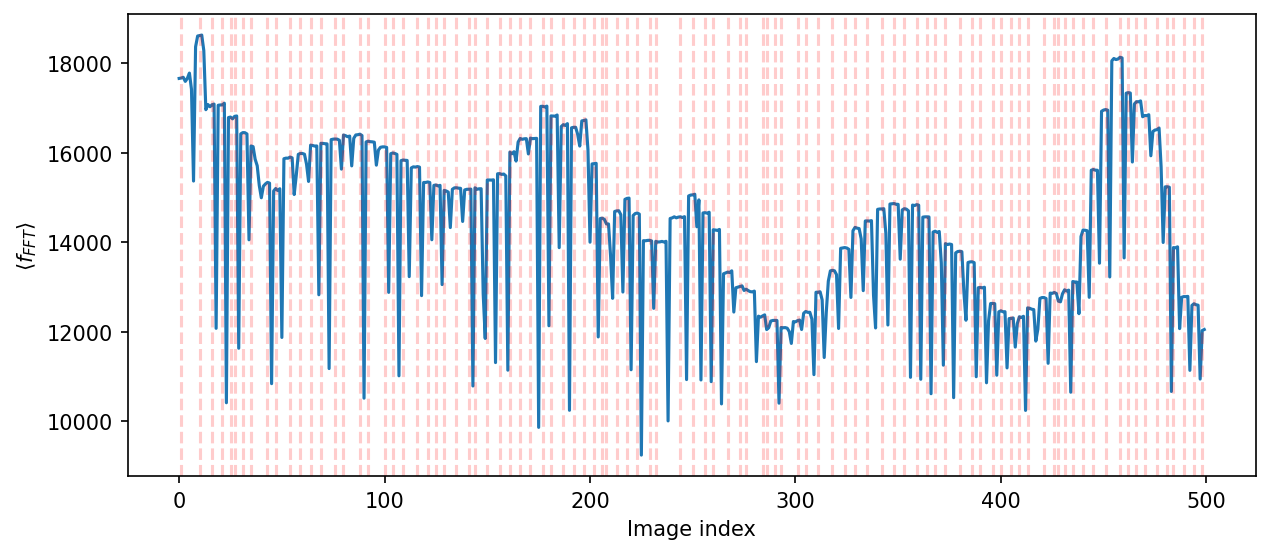

Found 97 stable images


In [3]:
stableImageIndices = st.identifyStableImages(images[:500], derThreshold=.05, debug=True)
print(f'Found {len(stableImageIndices)} stable images')

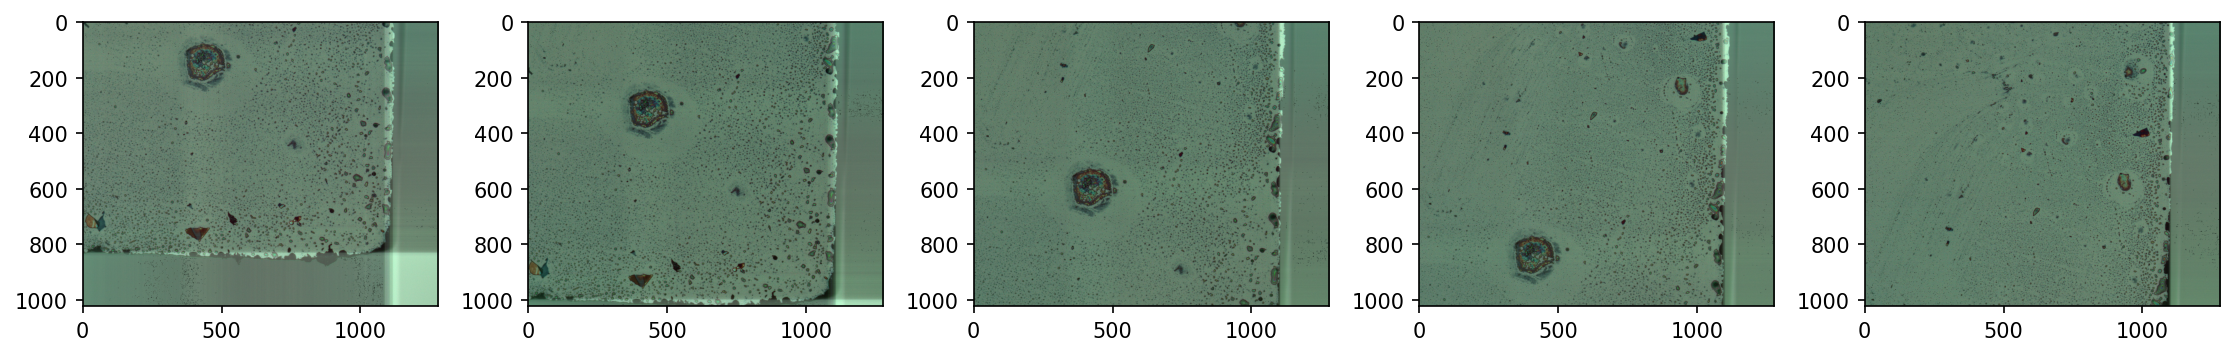

In [4]:
fig, ax = plt.subplots(1, 5, figsize=(15, 4))

imgArr = [filter(cv2.imread(images[i])) for i in stableImageIndices[:5]]

for i in range(len(imgArr)):
    ax[i].imshow(imgArr[i])

fig.tight_layout()
plt.show()

In [9]:
stitchedColumns = []

for j in tqdm.tqdm(range(int(np.ceil(len(stableImageIndices)/approxColumnSize)))):

    imgArr = [cv2.imread(images[i]) for i in stableImageIndices[max(j*approxColumnSize-columnOverlap//2, 0):min((j+1)*approxColumnSize + columnOverlap//2, len(stableImageIndices))]]

    newImages = []
    currentImages = imgArr

    while len(currentImages) > 0:

        for i in tqdm.tqdm(range(1, len(currentImages)-1, stitchImageSkip)):
            #print(len(currentImages))

            # try:
            stitcher = st.AffineStitcher(**stitcherSettings)
            stitched = stitcher.stitch(currentImages[max(i-stitchKernel,0):min(i+stitchKernel+1,len(currentImages))])

            newImages.append(stitched)

#             except Exception as e:
#                 print(e)
#                 fig, ax = plt.subplots(1, len(currentImages[max(i-stitchKernel,0):min(i+stitchKernel+1,len(currentImages))]))
#                 for k in range(len(currentImages[max(i-stitchKernel,0):min(i+stitchKernel+1,len(currentImages))])):
#                     ax[k].imshow(currentImages[max(i-stitchKernel,0):min(i+stitchKernel+1,len(currentImages))][k])
#                 plt.show()
                
#                 raise Exception()
#                 print('failed; moving on')

        currentImages = newImages
        newImages = []

    clear_output(wait=True)
    
    stitchedColumns.append(stitched)
    plt.imshow(stitched)
    plt.show()

clear_output(wait=True)

if len(stitchedColumns) > 1:
    fig, ax = plt.subplots(1, len(stitchedColumns), figsize=(3*len(stitchedColumns), 6))

    for i in range(len(stitchedColumns)):
        ax[i].imshow(stitchedColumns[i])

    fig.tight_layout()
    plt.show()
    
else:
    plt.imshow(stitchedColumns[0])
    plt.show()

  0%|                                                                     | 0/1 [00:02<?, ?it/s]


TypeError: Can't parse 'features'. Sequence item with index 0 has a wrong type

In [156]:
badImages = currentImages[max(i-stitchKernel,0):min(i+stitchKernel+1,len(currentImages))]

In [64]:
finalStitcherSettings = {'detector': 'sift',
                    'matcher_type': 'affine',
                    'confidence_threshold': 1.,
                    'crop': False}

stitcher = st.AffineStitcher(**finalStitcherSettings)
#stitched = stitcher.stitch(imgArr)
stitched = stitcher.stitch(stitchedColumns)

plt.imshow(stitched)
plt.show()

StitchingError: No match exceeds the given confidence threshold.

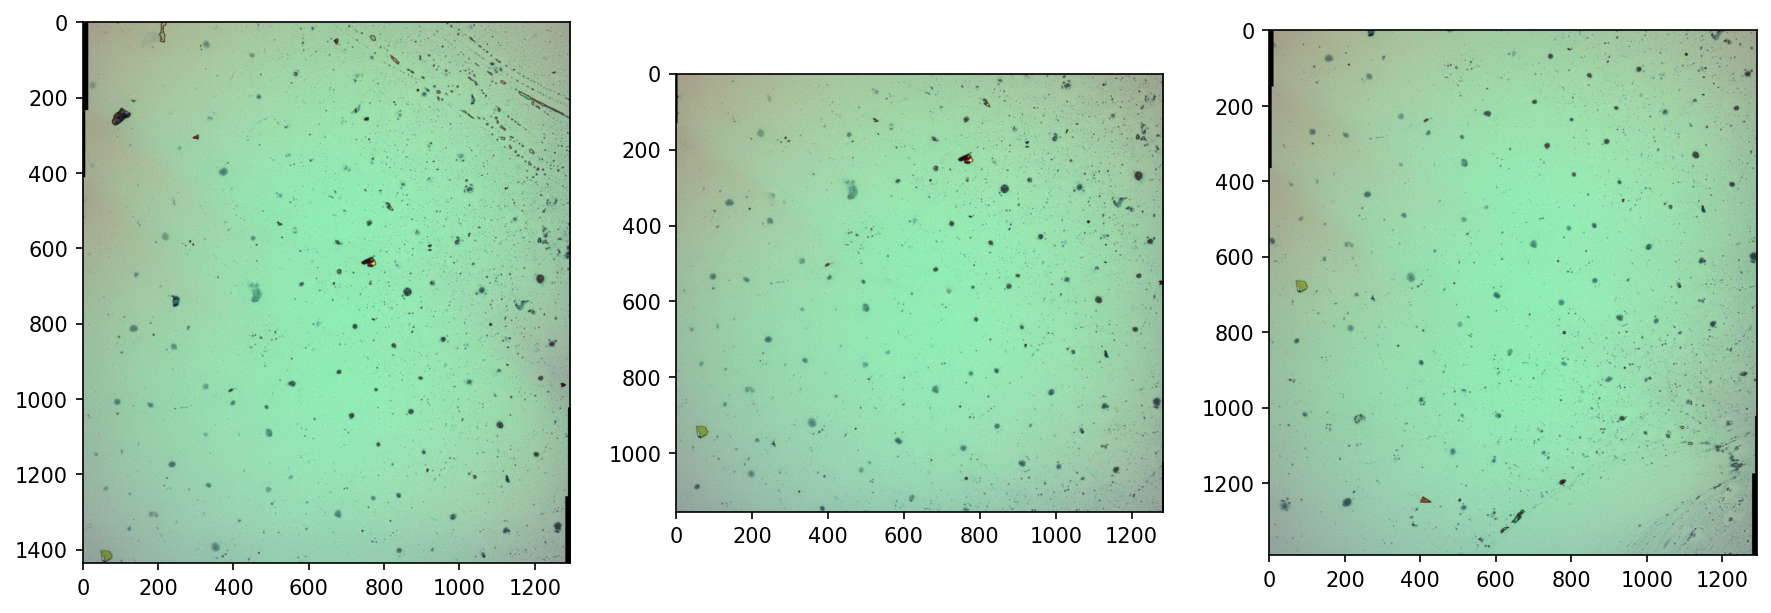

In [102]:
fig, ax = plt.subplots(1, len(badImages), figsize=(12,5))
for i in range(len(badImages)):
    ax[i].imshow(badImages[i])

fig.tight_layout()
plt.show()

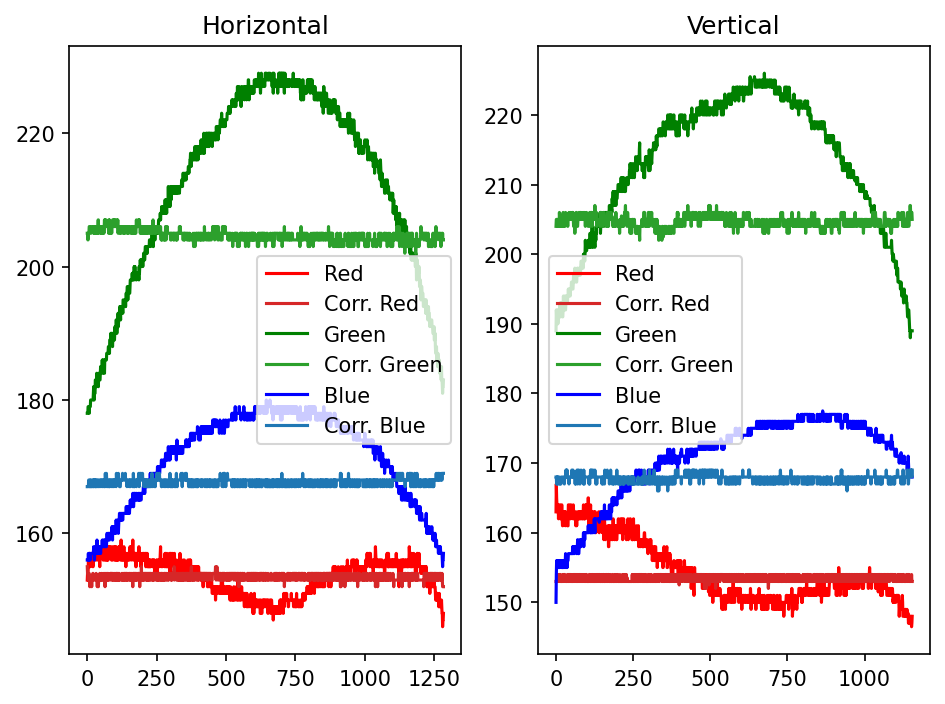

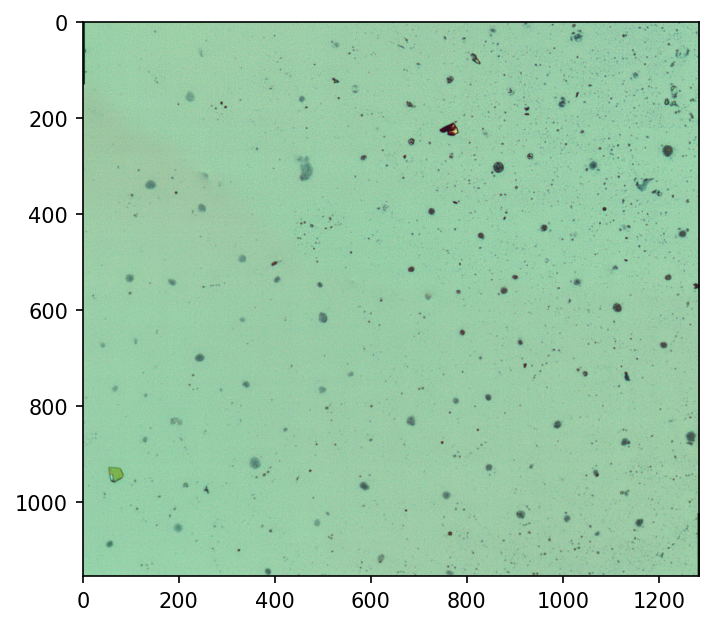

In [167]:
def filterBackground(img, tolerance=.05):
    backgroundColor = np.mean([np.median(img[i,:], axis=0) for i in range(img.shape[0])], axis=0)
    editedImg = img
    
    editedImg[np.sqrt(np.sum((img - backgroundColor)**2, axis=-1)) < tolerance*np.max(img),:] = 0
    return editedImg
    
def equalizeSpatialGradients(img, debug=False):
    horizontalGrad = np.array([np.median(img[:,i,:], axis=0) for i in range(img.shape[1])])
    verticalGrad = np.array([np.median(img[i,:,:], axis=0) for i in range(img.shape[0])])
    
    horizontalCorr = horizontalGrad - np.mean(horizontalGrad, axis=0)
    verticalCorr = verticalGrad - np.mean(verticalGrad, axis=0)
    
    corr = np.transpose([np.add.outer(horizontalCorr[:,i].T, verticalCorr[:,i].T) for i in range(3)])
    
    corrImg = img - corr
    corrImg = (corrImg - np.min(corrImg))
    corrImg /= np.max(corrImg)

    # Now make sure the image has the same type and min/max as the input
    if img.dtype == np.uint8:
        corrImg *= 255
        corrImg = corrImg.astype(np.uint8)
    
    if debug:        
        correctedHorizontalGrad = np.array([np.median(corrImg[:,i,:], axis=0) for i in range(img.shape[1])])
        correctedVerticalGrad = np.array([np.median(corrImg[i,:,:], axis=0) for i in range(img.shape[0])])

        fig, ax = plt.subplots(1, 2)
        labels = ['Red', 'Green', 'Blue']
        for i in range(3):
            ax[0].plot(horizontalGrad[:,i], label=labels[i], c=labels[i])
            ax[0].plot(correctedHorizontalGrad[:,i], label=f'Corr. {labels[i]}', c=f'tab:{labels[i]}')

        ax[0].set_title('Horizontal')
        ax[0].legend()
        for i in range(3):
            ax[1].plot(verticalGrad[:,i], label=labels[i], c=labels[i])
            ax[1].plot(correctedVerticalGrad[:,i], label=f'Corr. {labels[i]}', c=f'tab:{labels[i]}')

        ax[1].set_title('Vertical')
        ax[1].legend()
        fig.tight_layout()
        plt.show()

    return corrImg

plt.imshow(equalizeSpatialGradients(badImages[1], debug=True))
plt.show()

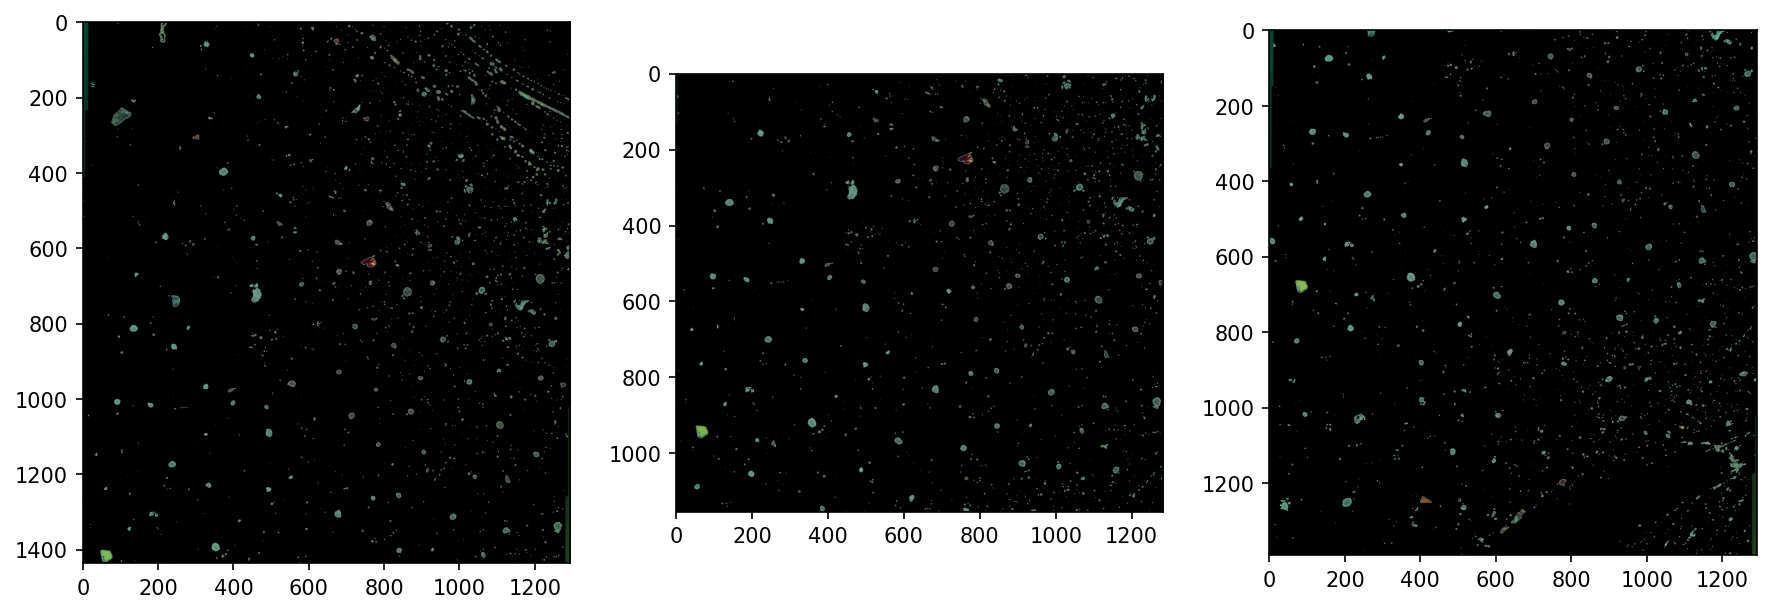

In [168]:
editedBadImages = []

for i in range(len(badImages)):
    editedBadImages.append(badImages[i])
    editedBadImages[-1] = filterBackground(equalizeSpatialGradients(editedBadImages[-1]), tolerance=.2)

fig, ax = plt.subplots(1, len(badImages), figsize=(12,5))
for i in range(len(badImages)):
    ax[i].imshow(editedBadImages[i])

fig.tight_layout()
plt.show()

In [170]:
editedBadImages[0].dtype

dtype('uint8')

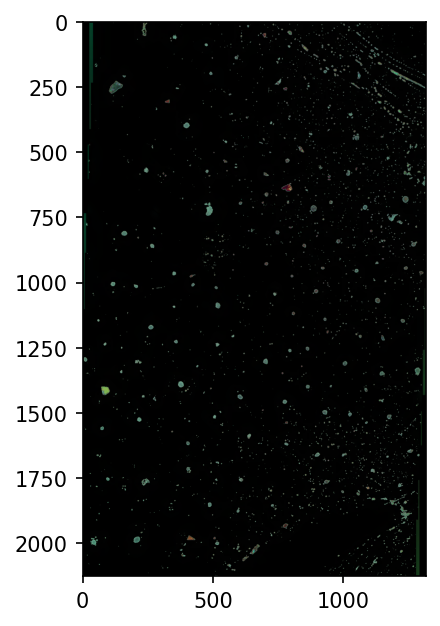

In [180]:
finalStitcherSettings = {'detector': 'orb',
                    'matcher_type': 'affine',
                    'confidence_threshold': .1,
                    'crop': False}

stitcher = st.AffineStitcher(**finalStitcherSettings)
#stitched = stitcher.stitch(imgArr)
stitched = stitcher.stitch(editedBadImages)

plt.imshow(stitched)
plt.show()

In [154]:
st.kernelFind(editedBadImages[2], editedBadImages[1], debug=True)

ValueError: could not broadcast input array from shape (1155,1284) into shape (1156,1292)